## Figure 4; Supplementary Figure 5; Supplementary Table 5

Analysis comparing non-UV and UV conditions to find that the 5U01 sequence seems to increase in binding for CREB1 and EGR1 after UV irradiation. 

### Files
The following files are used to generate the data:

1. Initial observation:
    1. CREB1_WC_ID0_alldata.txt
    2. CREB1_UV_ID1_alldata.txt
    3. EGR1_WC_ID2_alldata.txt
    4. EGR1_UV_ID3_alldata.txt
    1. CREB1_WC_ID0_7mers_1111111.txt
    2. CREB1_UV_ID1_7mers_1111111.txt
    3. EGR1_WC_ID2_7mers_1111111.txt
    4. EGR1_UV_ID3_7mers_1111111.txt
2. Follow-up experiments:
    1. CREB1_WC_ID38_alldata.txt
    2. CREB1_UV_ID39_alldata.txt
    3. EGR1_WC_ID40_alldata.txt
    4. EGR1_UV_ID41_alldata.txt
3. Meta data file:
    1. Signal_Increase_UV_5U01_Scatterplots.csv


### 3rd Party Packages

1. Bokeh - Plotting (Scatterplots)
2. Matplotlib - Plotting (Boxplot)
3. Numpy - ln function from np.log
4. Pandas - Dataframe usage
5. Seaborn - Plotting (Boxplots)
6. Scipy - Linear regression
7. Statsmodels: Multiple test correction

### UV Bind Analysis Core Imports

- uac.ols: Train OLS regression on sequences that cannot form pyrimidine dimers.
- uac.scale_uv_on_non_uv: Scale UV probes on Non-UV by making the slope of a linear regression for sequences that cannot form pyrimidine dimers equal to 1. 
- uac.read_kmer_file_pair: Given a pair of k-mer files, reads them as dataframes and merges them into one.

** Additional details can be found in the uvbind_analysis_core.py script.

### Abbreviations:

- pydi: Pyrimidine Dinucleotide
- df: DataFrame
- dn: Dinucleotide
- idx: index

#### Imports and Global variables

In [1]:
from __future__ import annotations
from collections import namedtuple
import os
import re


from bokeh.io import export_svg, export_png
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.models import CDSView, GroupFilter, Span
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests

import uvbind_analysis_core as uac

ALLDATA_FOLDER = "../../Data/AllData_Files"
KMER_FOLDER = "../../Data/Kmer_Files"
SCATTERPLOT_META_DATA = "Meta_Data/Signal_Increase_UV_5U01_Scatterplots.csv"
FIGS5_META_DATA = "Meta_Data/Meta_Data_S5B.csv"
DN_DESIGN_META_DATA = "Meta_Data/Array_86684_DN_Design.csv"

OUTPUT_FOLDER_MAIN = "../Figure_4"
OUTPUT_FOLDER_SUPP = "../Figure_S5"
OUTPUT_FOLDER_TABLE = "../Table_S5"


# Figure 6S Parameters
PALETTE = ("#2b8cbe", "#a6bddb", "black", "black") 
BOXPLOT_PALETTE = ("lightgrey", "grey") # (Non_UV, UV)
# Do we still need these global vars? - Used in FS6g, replace with updated meta?
CREB1_KMERS = ("CREB1_WC_ID0_7of9mers_1111111.txt",
               "CREB1_UV_ID1_7of9mers_1111111.txt")
EGR1_KMERS = ("EGR1_WC_ID2_7of9mers_1111111.txt",
               "EGR1_UV_ID3_7of9mers_1111111.txt")
# Panel A
PANEL_A_FILES = (("CREB1","Non_UV" ,"CREB1_WC_ID0_alldata.txt"),
              ("CREB1", "UV", "CREB1_UV_ID1_alldata.txt"),
              ("EGR1", "Non_UV", "EGR1_WC_ID2_alldata.txt"),
              ("EGR1", "UV", "EGR1_UV_ID3_alldata.txt"))

# Updated meta data
KMER_FILES = (("CREB1","Non_UV" ,"CREB1_WC_ID0_7of9mers_1111111.txt"),
              ("CREB1", "UV", "CREB1_UV_ID1_7of9mers_1111111.txt"),
              ("EGR1", "Non_UV", "EGR1_WC_ID2_7of9mers_1111111.txt"),
              ("EGR1", "UV", "EGR1_UV_ID3_7of9mers_1111111.txt"))
KMER_PROFILE_META_DATA = "Meta_Data/Meta_Data_F6S_Profile_Plots.csv"

# Figure 4 parameters
CREB1_HIGHLIGHT = ("Clst_CREB1_C1314_TD25_O2",
                   "Clst_CREB1_C604_TD25",
                   "Clst_CREB1_C1039_TD25")
EGR1_HIGHLIGHT = ("Clst_EGR1_C394_TD25",
                  "Clst_EGR1_C537_TD25",
                  "Clst_EGR1_C390_TD25")
KDE_BOUNDS = {"CREB1": ((5.8, 13),(0, 1.4)), # x_bounds, y_bounds
              "EGR1": ((5.8, 13),(0, 4))}

PDB_VAR_LIB = {"ELK1",
              "ETS1_monomer",
              "ETS1_dimer", 
              "Creb1", 
              "CTCF", 
              "Myc+Mad",
              "p53_1", 
              "RelA_dimer", 
              "Runx1", 
              "Stat3",
              "TBP",
              "TBP_Ariel_A"}

In [2]:
# Ensure output folders exist
for i in (OUTPUT_FOLDER_MAIN, OUTPUT_FOLDER_SUPP, OUTPUT_FOLDER_TABLE):
    os.makedirs(i, exist_ok=True)

### Table S5A: Scatterplot of non-Universal probes

#### (1) Read and display meta data

In [3]:
meta_data = pd.read_csv(SCATTERPLOT_META_DATA)
meta_data

,Panel,Protein,File_Non_UV,File_UV,Range_Start_X,Range_End_X,Range_Start_Y,Range_End_Y,Ticker_A_X,Ticker_B_X,Ticker_C_X,Ticker_A_Y,Ticker_B_Y,Ticker_C_Y
0,A,CREB1,CREB1_WC_ID0_alldata.txt,CREB1_UV_ID1_alldata.txt,50,75000,200,75000,50,2500,75000,200,2500,75000
1,A,EGR1,EGR1_WC_ID2_alldata.txt,EGR1_UV_ID3_alldata.txt,200,25000,1000,15000,250,2500,25000,1500,5000,15000


#### (2) Functions

In [4]:
PRIMER = uac.PRIMER

def return_group(x: str):
    """Return a substring representing the group a label belongs to."""
    # Determine how many subgroups deliminated by '_' to return
    n = 3
    if x.startswith("MITF_Ex"):
        n = 4
    elif x.startswith("random_damageable"):
        n = 2
    # Return the subgroup
    return '_'.join(x.split('_')[:n])


def filter_alldata_dataframe(dataframe: pd.DataFrame,
                             primer: str = PRIMER) -> pd.DataFrame:
    """Remove flagged sequence and non-double stranded sequences.

    Given a dataframe with column names in the alldata format, returns
    a dataframe with all flagged rows, rows with no sequence, and
    rows with a sequence without a primer removed.
    """
    alexa = dataframe.columns[7]
    # Filter out flags
    dataframe = dataframe[(dataframe["Cy3Flags"].isnull()) &
                          (dataframe[f"{alexa}Flags"].isnull())]
    # Remove rows with no sequence
    dataframe = dataframe[dataframe["Sequence"].notnull()]
    # Remove rows without primer
    dataframe = dataframe[dataframe["Sequence"].str.endswith(primer)]
    dataframe = dataframe.reset_index(drop=True)
    return dataframe


def replicate_values(dataframe: pd.DataFrame,
                     column: str,
                     min_count: int = 2) -> pd.DataFrame:
    """Return a dataframe of values with a minimum number of replicates.

    Given a dataframe and column, finds the number of replicates of that
    column and returns a dataframe with a minimum amount of replicates.
    """
    # Calculate value counts and return as a dataframe
    count = pd.DataFrame(dataframe[column].value_counts()).reset_index()
    # Rename the columns
    count = count.rename(columns={column: "Count"})
    count = count.rename(columns={"index": column})
    # Query for items that have a minimum value count
    count = count.query("Count >= @min_count")
    return count


def process_alldata_file(file_path: str) -> pd.DataFrame:
    """Given an alldata file, return a dataframe of custom sequences.

    Takes an alldata file and does the following pipeline:
    1. Read as a dataframe
    2. Remove universal sequences
    3. Remove trailing replicate labels so replicate data can be queried
    4. Subset the column into the sequence name, sequence, and signal values

    Returns a dataframe with a Name, Sequence, and Signal columns.
    """
    # Read dataframe
    dataframe = pd.read_csv(file_path, sep='\t')
    alexa = dataframe.columns[7]  # Name is the specific alexa wavelength for the experiment
    dataframe = filter_alldata_dataframe(dataframe)
    # Remove universal UV-Bind Probes
    dataframe = dataframe[~dataframe["Name"].str.startswith("All")]
    dataframe = dataframe.reset_index(drop=True)
    # Remove trailing replicate label for replicate counting
    dataframe["Name_Group"] = dataframe["Name"]\
        .apply(lambda x: '_'.join(x.split('_')[:-1]))
    # Filter for sequences with 2+ replicates
    replicate_counts = replicate_values(dataframe, "Name_Group")
    name_set = set(replicate_counts["Name_Group"])
    dataframe = dataframe[dataframe["Name_Group"]
                          .isin(name_set)].reset_index(drop=True)
    # Subset by name, sequence and signal columns
    dataframe = dataframe[["Name", "Sequence", alexa]]
    dataframe = dataframe.rename(columns={alexa: "Signal"})
    return dataframe


def filter_rep(x):
    """Remove the _r suffix from a label."""
    if re.search(pattern="_r\d*$", string=x):
        return '_'.join(x.split('_')[:-1])
    else:
        return x
    
def decompress_tbp_labels(df):
    dup = df[df["Name"].apply(lambda x: "Ariel_A" in x and "Ariel_G" in x)].copy()
    dup = dup.reset_index(drop=True)
    dup["Group"] = "TBP_Ariel_G"
    df = pd.concat([df, dup]).reset_index(drop=True)
    return df


def show_scatterplot(plot_df: pd.DataFrame,
                     x: str,
                     y: str,
                     color_on: str,
                     title: str,
                     color_map: str = "viridis"):
    """Show a scatterplot of 2 columns in a dataframe."""
    figure(figsize=(8, 8), dpi=90)
    plt.scatter(plot_df[x],
               plot_df[y],
               c=plot_df[color_on],
               cmap=color_map)
    plt.title(title)
    plt.colorbar()
    plt.axline((1, 1), slope=1, color='black')
    plt.show()


def show_hexbin(plot_df: pd.DataFrame,
                x: str,
                y: str,
                color_on: str,
                title: str,
                color_map: str = "viridis"):
    """Show a hexbin of 2 columns in a dataframe aggregating by median."""
    figure(figsize=(8, 8), dpi=80)
    plt.hexbin(plot_df[x],
               plot_df[y],
               C=plot_df[color_on],
               reduce_C_function=np.median,
               gridsize=50,
               cmap=color_map)
    plt.title(title)
    plt.axline((1, 1), slope=1, color='black')
    plt.colorbar()
    plt.show()
    
def scatterplot_of_groups(plot_df,
                          plot_range_x,
                          plot_range_y,
                          circle_size,
                          palette,
                          ticker_x,
                          ticker_y,
                          groups,
                          x,
                          y):
    """"""
    # Create bokeh plot object
    p = figure(width=800, height=800, x_range=plot_range_x, y_range=plot_range_y)
    source = ColumnDataSource(plot_df)
    # For each group and their corresponding palette color, draw datapoints
    for i, color in zip(groups, palette):
        view = CDSView(source=source,
                      filters=[GroupFilter(column_name="Group", group=i)])
        p.circle(x,
                 y,
                 source=source,
                 view=view,
                 size=circle_size,
                 color=color)
    p.xaxis.ticker = ticker_x
    p.yaxis.ticker = ticker_y
    p.xaxis.major_label_text_font_size = '0pt'
    p.yaxis.major_label_text_font_size = '0pt'
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.xaxis.minor_tick_line_color = None
    p.yaxis.minor_tick_line_color = None
    p.toolbar_location = None
    return p


#### (2) Analysis

In [5]:
# Read in each file and concatinate into a single df
panel_a_data = []
for protein, condition, file in PANEL_A_FILES:
    df = process_alldata_file(f"{ALLDATA_FOLDER}/{file}")
    df["Group"] = df["Name"].apply(lambda x: x.split('-')[0])
    df["Group"] = df["Group"].apply(lambda x: filter_rep(x))
    df = decompress_tbp_labels(df)
    df["Name"] = df["Name"].apply(lambda x: "_".join(x.split("_")[:-1]))
    df["Sequence"] = df["Sequence"].apply(lambda x: x[:25])
    df = df.groupby(by=["Group","Name", "Sequence"]).aggregate(np.median).reset_index()
    df["Protein"] = protein
    df["Condition"] = condition
    panel_a_data.append(df)
panel_a_data = pd.concat(panel_a_data).reset_index(drop=True)
panel_a_data = panel_a_data[panel_a_data["Group"].isin(PDB_VAR_LIB)]
del panel_a_data["Name"]
# Output Table S5A
panel_a_data["Signal"] = panel_a_data["Signal"].apply(lambda x: np.log(x))
panel_a_data["Group"] = panel_a_data["Group"].apply(lambda x: "5U01" if x == "RelA_dimer" else "Other")
panel_a_data = panel_a_data.sort_values(by="Group").reset_index(drop=True)
#panel_a_data.to_csv(f"{OUTPUT_FOLDER_TABLE}/Table_S5A.csv", index=False)
panel_a_data = panel_a_data.pivot(index=["Group","Sequence"],
                   values="Signal",
                   columns=["Protein", "Condition"]).reset_index()
panel_a_data.columns = ["_".join(i) for i in panel_a_data.columns]
panel_a_data.columns = list(map(lambda x: x.rstrip('_'), panel_a_data.columns))
panel_a_data.to_csv(f"{OUTPUT_FOLDER_TABLE}/Table_S5A.csv", index=False)
panel_a_data

,Group,Sequence,CREB1_Non_UV,CREB1_UV,EGR1_UV,EGR1_Non_UV
0,5U01,ACGGAAATTCCCGGGAATTTCCGCG,4.757891,7.783016,9.059808,7.613325
1,5U01,CCGGAAATTCCCGGGAATTTCCGCG,4.795791,7.829630,9.110741,7.486613
2,5U01,GAGGAAATTCCCGGGAATTTCCGCG,4.844187,7.780512,9.090486,7.577634
3,5U01,GCAGAAATTCCCGGGAATTTCCGCG,4.757891,7.674385,9.049232,7.464223
4,5U01,GCCGAAATTCCCGGGAATTTCCGCG,4.653960,7.740664,9.214880,7.744570
...,...,...,...,...,...,...
556,Other,GCGCACCTTTCCCGTAAATCATACA,6.135565,7.274826,8.461786,7.610853
557,Other,GCGCACGTTTCCCGTAAATCATACA,6.553933,7.393571,8.194920,7.307538
558,Other,GCGCACTTTTCCCGTAAATCATACA,6.540308,7.485211,8.407155,7.605890
559,Other,GCGCAGATTTCCCGTAAATCATACA,5.930918,7.298783,8.305608,7.038784


### Figure S5A

Scatterplot of the non-Universal probes in supplementary figure 5 for CREB1 and EGR1. The sequences corresponding to a single-nucleotide variation design of the DNA sequence in PDB ID 5U01 are highlighted in a different color. 

#### (1) Read and display meta data

In [6]:
meta_data = pd.read_csv(SCATTERPLOT_META_DATA)
meta_data

,Panel,Protein,File_Non_UV,File_UV,Range_Start_X,Range_End_X,Range_Start_Y,Range_End_Y,Ticker_A_X,Ticker_B_X,Ticker_C_X,Ticker_A_Y,Ticker_B_Y,Ticker_C_Y
0,A,CREB1,CREB1_WC_ID0_alldata.txt,CREB1_UV_ID1_alldata.txt,50,75000,200,75000,50,2500,75000,200,2500,75000
1,A,EGR1,EGR1_WC_ID2_alldata.txt,EGR1_UV_ID3_alldata.txt,200,25000,1000,15000,250,2500,25000,1500,5000,15000


#### (2) Create Scatterplots

In [7]:
panel_a_data["Sequence_Group"] = panel_a_data["Group"]

panel_a_meta = meta_data[meta_data["Panel"] == "A"].reset_index(drop=True)
for row in panel_a_meta.itertuples():
    # Transform plot range and ticker settings to ln scale
    ln_plot_range_x = list(map(np.log, (row.Range_Start_X, row.Range_End_X)))
    ln_plot_range_y = list(map(np.log, (row.Range_Start_Y, row.Range_End_Y)))
    ln_plot_ticker_x = list(map(np.log,
                              (row.Ticker_A_X, row.Ticker_B_X, row.Ticker_C_X)))
    ln_plot_ticker_y = list(map(np.log,
                              (row.Ticker_A_Y, row.Ticker_B_Y, row.Ticker_C_Y)))
    # Plot
    plot = scatterplot_of_groups(panel_a_data,
                                  ln_plot_range_x,
                                 ln_plot_range_y,
                                  10,
                                  (PALETTE[2], PALETTE[0]),
                                  ln_plot_ticker_x,
                                 ln_plot_ticker_y,
                                 ("Other", "5U01"),
                                 x = f"{row.Protein}_Non_UV",
                                 y = f"{row.Protein}_UV")
    plot.output_backend = "svg"
    export_svg(filename=f"{OUTPUT_FOLDER_SUPP}/Scatterplot_{row.Protein}_A.svg",
               obj=plot)    

### Figure S5B

Given data from a follow-up experiment, Prediction intervals based on an OLS of non-damageable sequences in the library
2. The 5U01 full and half sequences in 2 different colors
3. Sequences that either contain a consensus sequence or a 1-nt variation. 

In [8]:
panel_b_meta = pd.read_csv(FIGS5_META_DATA)
panel_b_meta

,Panel,Protein,File_Non_UV,File_UV,Range_Start,Range_End,Ticker_A,Ticker_B,Ticker_C
0,C,CREB1,CREB1_WC_ID38_alldata.txt,CREB1_UV_ID39_alldata.txt,500,110000,1000,10000,100000
1,C,EGR1,EGR1_WC_ID40_alldata.txt,EGR1_UV_ID41_alldata.txt,500,110000,1000,10000,100000


In [9]:
consensus_design = pd.read_csv(DN_DESIGN_META_DATA)
consensus_design

,Protein,Group,Name,WT_Seq,Variant_ID,Binding_Site,Start,End
0,CREB1,DN_CREB1_CrystalTGACGTCA,DN_CREB1_CrystalTGACGTCA_posW->WT,GCATACGGCTGACGTCAGCCACATACGCACACATACACATACACAC...,0,TGACGTCA,9,17
1,CREB1,DN_CREB1_TGACGTCA,DN_CREB1_TGACGTCA_posW->WT,GCATACATATGACGTCATATGTATGCGCACACATACACATACACAC...,1,TGACGTCA,9,17
2,EGR1,DN_EGR1_CGCCCACGC,DN_EGR1_CGCCCACGC_posW->WT,ACGTATGCACGCCCACGCGTATGTACGCACACATACACATACACAC...,3,CGCCCACGC,9,18
3,EGR1,DN_EGR1_GCGTGGGCG,DN_EGR1_GCGTGGGCG_posW->WT,ACATACGCGTGGGCGTGCATACGTACGCACACATACACATACACAC...,6,GCGTGGGCG,6,15


#### (1) Functions and Named Tuples

In [10]:
# Named tuple for group names based of dinucelotide variant designs
Dinucleotide_Group = namedtuple("DN_Group", ["consensus", "snv", "dnv"])

def dinucleotide_group_names(query_df: pd.DataFrame,
                             design_df: pd.DataFrame) -> pd.DataFrame:
    """Labels sequences into consensus, snv, or dnv across multiple groups.
    
    For dinucleotide variation assays, probes can be in one of the following
    categories:
    
    1. Consensus: The sequence is the WT or has a variation outside the binding
    site.
    2. SNV: The sequence has a 1-nt variation in the binding site
    3. DNV: The sequences has a 2-nt variation in the binding site
    
    A namedtuple is returned containing sets of sequence names belonging to each
    group.
    """
    consensus_set = set()
    snv_set = set()
    dnv_set = set()
    for row in design_df.itertuples():
        # Query for a group of sequences
        df = query_df[query_df["Name"].str.startswith(row.Group)]
        df = df.reset_index(drop=True)
        for name, sequence in zip(df["Name"], df["Sequence"]):
            binding_site = sequence[row.Start:row.End]
            if binding_site == row.Binding_Site:
                consensus_set.add(name)
            elif uac.hamming_distance(binding_site, row.Binding_Site) == 1:
                snv_set.add(name)
            elif uac.hamming_distance(binding_site, row.Binding_Site) == 2:
                dnv_set.add(name)
            else:
                raise ValueError("Unexpected difference found")
    return Dinucleotide_Group(consensus_set, snv_set, dnv_set)


#### (2) Analysis:

In [11]:
wt_dict = {"CREB1":("DN_CREB1_CrystalTGACGTCA","DN_CREB1_TGACGTCA", "DN_RELA_Double", "DN_RELA_Single" ),
           "EGR1": ("DN_EGR1_CGCCCACGC", "DN_EGR1_GCGTGGGCG", "DN_RELA_Double", "DN_RELA_Single")}
panel_b_data = []
for row in panel_b_meta.itertuples():
    # Read the comparison, scale UV on non-UV
    df = uac.scale_uv_on_non_uv(f"{ALLDATA_FOLDER}/{row.File_Non_UV}",
                                f"{ALLDATA_FOLDER}/{row.File_UV}")
    # Add OLS analysis
    df = uac.ols(df, "Signal_Non_UV", "Signal_UV", 0.01, "Has_PyDi")
    df = df[df["Name"].apply(lambda x: any(x.startswith(y) for y in wt_dict[row.Protein]))]
    groups = []
    for name in df["Name"]:
        if name.startswith("DN_RELA_Double"):
            groups.append("Full_5U01")
        elif name.startswith("DN_RELA_Single"):
            groups.append("Half_5U01")
        else:
            groups.append("Other")
    df["Group"] = groups
    # Transform plot range and ticker settings to ln scale
    ln_plot_range = list(map(np.log, (row.Range_Start, row.Range_End)))
    ln_plot_ticker = list(map(np.log,
                              (row.Ticker_A, row.Ticker_B, row.Ticker_C)))
    # Plot
    plot = uac.scatterplot_of_groups(df,
                                 ln_plot_range,
                                 10,
                                 ("#2b8cbe", "#a6bddb", "black"),
                                 ln_plot_ticker,
                                 ("Full_5U01", "Half_5U01", "Other"),
                                 True)
    plot.output_backend = "svg"
    export_svg(filename=f"{OUTPUT_FOLDER_SUPP}/FigS5B_{row.Protein}.svg",
               obj=plot)
    df["Protein"] = row.Protein
    panel_b_data.append(df)


### Table S5B

In [12]:
table_s5b = pd.concat(panel_b_data).reset_index(drop=True)
table_s5b = table_s5b[["Group",
                       "Sequence",
                       "Signal_Non_UV",
                       "Signal_UV",
                       "Prediction_Upper",
                       "Prediction_Lower",
                       "Predicted",
                       "Protein"]]
table_s5b["Sequence"] = table_s5b["Sequence"].apply(lambda x: x[:25])
table_s5b = table_s5b.sort_values(by=["Protein", "Group", "Sequence"]).reset_index(drop=True)
table_s5b.to_csv(f"{OUTPUT_FOLDER_TABLE}/Table_S5B.csv", index=False, float_format='%g')

### Figure S6C-F: K-mer profile comparison

For groups of sequences related to all possible 1-nt variations of consensus sites, their flanking sequence and the 5U01 sequence, generate k-mer profiles. Each profile shows the e-score for the overlapping k-mer from a specified dataset. These profiles can then be compared across conditions.

#### (1) Kmer profile meta data:

In [13]:
# Read meta data and display
kmer_profile_meta = pd.read_csv(KMER_PROFILE_META_DATA)
kmer_profile_meta

,Scored_Sequence_Group,Protein_Kmer_Source,Condition
0,5U01,EGR1,UV
1,5U01,EGR1,Non_UV
2,5U01,CREB1,UV
3,5U01,CREB1,Non_UV
4,CREB1,CREB1,UV
5,CREB1,CREB1,Non_UV
6,EGR1,EGR1,UV
7,EGR1,EGR1,Non_UV


#### (2) Functions:

In [14]:
def kmer_dict_from_df(input_df, condition, protein):
    """DOC"""
    df= input_df[(input_df["Condition"] == condition) &
                        (input_df["Protein"] == protein)]
    result = dict(zip(df["7-mer"], df["E-score"]))
    result.update(dict(zip(df["7-mer.1"], df["E-score"])))
    return result

def kmer_scores(kmer_dict, sequence, k=7, thr=0.35):
    """DOC"""
    pos_scores = []
    for i in range(len(sequence) - k + 1):
        subsequence = sequence[i:i+k]
        score = kmer_dict[subsequence]
        pos_scores.append((i, score))
    result = pd.DataFrame(pos_scores)
    result = result.rename(columns={0:"Position", 1:"Score"})
    result["Thr_Group"] = "Above" if max(result["Score"]) >= thr else "Below"
    return result

def kmer_scores_across_sequences(kmer_dict, sequence_list, k=7):
    """DOC"""
    dfs = []
    for sequence in sequence_list:
        kmer_score_df = kmer_scores(kmer_dict, sequence, k=k)
        kmer_score_df["Sequence"] = sequence
        dfs.append(kmer_score_df)
    result = pd.concat(dfs).reset_index(drop=True)
    return result

def score_sequence_group(sequences, KMER_FILES=KMER_FILES):
    dfs = []
    for protein, condition, file in KMER_FILES:
        kmer_dict = kmer_dict_from_df(kmer_df, condition, protein)
        score_df = kmer_scores_across_sequences(kmer_dict, sequences)
        score_df["Condition"] = condition
        score_df["Protein"] = protein
        dfs.append(score_df)
    result = pd.concat(dfs).reset_index(drop=True)
    return result


def kmer_profile_plot(scored_sequences_df,
                      protein,
                      condition,
                      threshold=0.35):
    """Makes a profile plot of k-mer scores for given parameters.
    
    Given a scored sequence dataframe, protein, condition, generate a bokeh figure with
    line plots for each unique sequence. Add a horizontal, dashed line indicating a score
    threshold.
    """
    # Subset the scored sequence dataframe by condition and protein
    plot_df = scored_sequences_df.query("Protein == @protein & Condition == @condition")
    # Create a bokeh figure object
    p = figure(y_range=(-0.52, 0.55))
    # For the subsetted dataframe, get all unique sequences and make a line plot for each
    unique_sequences = list(set(plot_df["Sequence"]))
    for seq in unique_sequences:
        df = plot_df[plot_df["Sequence"] == seq].sort_values(by="Position")
        p.line(df["Position"], df["Score"], color="black", line_width=2, alpha=0.15)
    # Plot a horizontal, dashed line indicating the threshold
    hline = Span(location=threshold,
                 dimension='width',
                 line_color='black',
                 line_dash='dashed',
                 line_width=3)
    hline2 = Span(location=0.5,
                 dimension='width',
                 line_color='black',
                 line_dash='dashed',
                 line_width=3)
    p.renderers.extend([hline])
    p.renderers.extend([hline2])
    # Set plot parameters for the grid line color, ticks, and outline
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.xaxis.minor_tick_line_color = None
    p.yaxis.minor_tick_line_color = None
    p.xaxis.major_label_text_font_size = '0pt'
    p.yaxis.major_label_text_font_size = '0pt'
    p.outline_line_width = 1
    p.outline_line_color = 'black'
    # Remove toolbar and grids
    p.toolbar_location = None
    p.xgrid.visible = False
    p.ygrid.visible = False
    # Return the plot object
    return p

#### (3) Read and concatinate k-mer dataframes:

In [15]:
# Read k-mer files, label, and concatinate into a single dataframe
dfs = []
for protein, condition, file in KMER_FILES:
    df = pd.read_csv(f"{KMER_FOLDER}/{file}", sep='\t')
    # Subset columns by k-mer and e-score
    df = df[["7-mer", "7-mer.1", "E-score"]]
    # Add information on the condition and protein
    df["Condition"] = condition
    df["Protein"] = protein
    dfs.append(df)
kmer_df = pd.concat(dfs).reset_index(drop=True)
# Show kmer_df
kmer_df

,7-mer,7-mer.1,E-score,Condition,Protein
0,AAAAAAA,TTTTTTT,0.07776,Non_UV,CREB1
1,AAAAAAC,GTTTTTT,0.03014,Non_UV,CREB1
2,AAAAAAG,CTTTTTT,0.07091,Non_UV,CREB1
3,AAAAAAT,ATTTTTT,0.02219,Non_UV,CREB1
4,AAAAACA,TGTTTTT,0.12400,Non_UV,CREB1
...,...,...,...,...,...
32763,TTGCCAA,TTGGCAA,-0.11773,UV,EGR1
32764,TTGGAAA,TTTCCAA,0.16756,UV,EGR1
32765,TTGTAAA,TTTACAA,0.01032,UV,EGR1
32766,TTTAAAA,TTTTAAA,0.29989,UV,EGR1


#### (4) Analysis:

In [16]:
panel_a_data

,Group,Sequence,CREB1_Non_UV,CREB1_UV,EGR1_UV,EGR1_Non_UV,Sequence_Group
0,5U01,ACGGAAATTCCCGGGAATTTCCGCG,4.757891,7.783016,9.059808,7.613325,5U01
1,5U01,CCGGAAATTCCCGGGAATTTCCGCG,4.795791,7.829630,9.110741,7.486613,5U01
2,5U01,GAGGAAATTCCCGGGAATTTCCGCG,4.844187,7.780512,9.090486,7.577634,5U01
3,5U01,GCAGAAATTCCCGGGAATTTCCGCG,4.757891,7.674385,9.049232,7.464223,5U01
4,5U01,GCCGAAATTCCCGGGAATTTCCGCG,4.653960,7.740664,9.214880,7.744570,5U01
...,...,...,...,...,...,...,...
556,Other,GCGCACCTTTCCCGTAAATCATACA,6.135565,7.274826,8.461786,7.610853,Other
557,Other,GCGCACGTTTCCCGTAAATCATACA,6.553933,7.393571,8.194920,7.307538,Other
558,Other,GCGCACTTTTCCCGTAAATCATACA,6.540308,7.485211,8.407155,7.605890,Other
559,Other,GCGCAGATTTCCCGTAAATCATACA,5.930918,7.298783,8.305608,7.038784,Other


In [17]:
# Get sequence data from design
for row in panel_b_meta.itertuples():
    # Read the comparison, scale UV on non-UV
    sequence_library_b = uac.scale_uv_on_non_uv(f"{ALLDATA_FOLDER}/{row.File_Non_UV}",
                                f"{ALLDATA_FOLDER}/{row.File_UV}")
    break

sequence_dict = {}
sequence_dict["CREB1"] = sequence_library_b[(sequence_library_b["Name"].str.startswith("DN_CREB1_TGACGTCA")) &
                               (sequence_library_b["Name"].str.contains("-DN"))]["Sequence"]
sequence_dict["EGR1"] = sequence_library_b[(sequence_library_b["Name"].str.startswith("DN_EGR1_CGCCCACGC")) &
                               (sequence_library_b["Name"].str.contains("-DN"))]["Sequence"]

for protein, condition, file in PANEL_A_FILES:
    sequence_library_a = process_alldata_file(f"{ALLDATA_FOLDER}/{file}")
    break
sequence_dict["5U01"] = sequence_library_a[(sequence_library_a["Name"].str.startswith("RelA"))]["Sequence"]

In [18]:
# Create a dictionary with keys as group names and values as sequence lists
# Add pd.Series to given groups


for key in sequence_dict:
    # convert the pd.Series into a list of sequence subset by the first 25 characters
    sequence_dict[key] = list(map(lambda x: x[:25], sequence_dict[key]))
    # Score the sequences and save as a pd.DataFrame
    sequence_dict[key] = score_sequence_group(sequence_dict[key])
    
# Create profile plots based on parameters in k-mer profile plot meta data
for row in kmer_profile_meta.itertuples():
    plot = kmer_profile_plot(sequence_dict[row.Scored_Sequence_Group],
                             row.Protein_Kmer_Source,
                             row.Condition)
    plot.output_backend = "svg"
    export_svg(plot, filename=(f"{OUTPUT_FOLDER_SUPP}/{row.Protein_Kmer_Source}_"
                               f"{row.Condition}_{row.Scored_Sequence_Group}.svg"))
    

### Figure S6G: Unique k-mer boxplot comparison

Given the increase is repeatable, could the k-mer data between non-UV and UV offer an explanation as to why the increase occurs? This analysis:

1. Retrieves all 5U01 sequences and finds all unique k-mers. 
2. Subsets the CREB1 and EGR1 k-mer data by thes k-mers
3. Determines if there a difference between non-UV and UV conditions for these k-mers

A wilcoxon rank-sum test and benjamini-hochberg correction results are saved as a table and a boxplot of the data is saved as a svg file. 

,Protein,P_Value,FDR
0,CREB1,1.130440e-11,1.130440e-11
1,EGR1,2.000925e-12,4.001851e-12


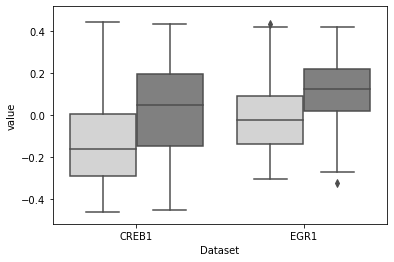

In [19]:
# Get 5u01 sequences from panel A as a list
#sequences_5u01 = panel_a_data[(panel_a_data["Protein"] == "CREB1") &
#                              (panel_a_data["Name"].str.startswith("RelA"))]
sequences_5u01 = list(panel_a_data[panel_a_data["Group"] == "5U01"]["Sequence"])
# Determine all unique 7-mers from the list of 5u01 sequences
unique_5u01_kmers = set()
for sequence in sequences_5u01:
    unique_5u01_kmers.update(uac.unique_kmers(sequence, 7))
# For each transcription factor
kmer_dfs = []
for kmer_files, tf in ((CREB1_KMERS, "CREB1"),
                         (EGR1_KMERS, "EGR1")):
    # Read the k-mer data as a pd.DataFrame
    non_uv_file, uv_file = kmer_files
    kmers = uac.read_kmer_file_pair(f"{KMER_FOLDER}/{non_uv_file}",
                                    f"{KMER_FOLDER}/{uv_file}",
                                    ("_Non_UV", "_UV"))
    # Subset it by those k-mers present in 5U01 sequences
    kmers_5u01 = kmers[(kmers["7-mer"].isin(unique_5u01_kmers)) |
                      (kmers["7-mer.1"].isin(unique_5u01_kmers))]
    kmers_5u01 = kmers_5u01.reset_index(drop=True)
    # Add information on the TF, append it to the dataframes processed
    kmers_5u01["Dataset"] = tf
    kmer_dfs.append(kmers_5u01)
# Concatintate dataframes into one
kmer_measurements_5u01 = pd.concat(kmer_dfs).reset_index(drop=True)
# Compare groups with wilcoxon rank sum test
wilcoxon_results = []
for dataset, df in kmer_measurements_5u01.groupby(by="Dataset"):
    ranksum_result = stats.ranksums(df["E-score_Non_UV"], df["E-score_UV"])
    wilcoxon_results.append((dataset, ranksum_result.pvalue))
# Store the results as a pd.DataFrame
escore_comparison = pd.DataFrame(wilcoxon_results)
escore_comparison = escore_comparison.rename(columns={0:"Protein", 1:"P_Value"})
# Benjamini correction for multiple tests to produce false discovery rates
fdr_values = multipletests(escore_comparison["P_Value"], method="fdr_bh")[1]
escore_comparison["FDR"] = fdr_values
# Save results
escore_comparison.to_csv(f"{OUTPUT_FOLDER_SUPP}/Panel_E_Statistics.csv")
# Create a boxplot of the data and save
# Transform the data to long form
plot_df = pd.melt(kmer_measurements_5u01,
                  id_vars=['7-mer', "Dataset"],
                  value_vars=['E-score_Non_UV', "E-score_UV"])
# Create a boxplot
sns.boxplot(x="Dataset", y="value", hue="variable",
            data=plot_df,
            palette = BOXPLOT_PALETTE,
           hue_order=["E-score_Non_UV", "E-score_UV"])
plt.ylim(-0.52, 0.52)
plt.legend([],[], frameon=False)
plt.savefig(f"{OUTPUT_FOLDER_SUPP}/Panel_E_Boxplot.svg")
escore_comparison

### Figure 4A-B: Sequences of concatinated k-mers plotting

Scatterplot comparing sequences made of concatinated k-mers that had higher E-scores in UV conditions than non-UV conditions (UV-preffered). The plots are colored in the following priority:

1. Green: Sequences with a consensus sequence of the given transcription factor
2. Light Green: Sequences with a 1-nt variation from the consensus sequences
3. Black: Sequences made from concatinated UV-preffered k-mers
4. Grey: Sequences used to train the OLS model

The data uses the same information as panel C for Figure S6, with the only changes being the sequences being plotted. 

In [20]:
panel_b_meta

,Panel,Protein,File_Non_UV,File_UV,Range_Start,Range_End,Ticker_A,Ticker_B,Ticker_C
0,C,CREB1,CREB1_WC_ID38_alldata.txt,CREB1_UV_ID39_alldata.txt,500,110000,1000,10000,100000
1,C,EGR1,EGR1_WC_ID40_alldata.txt,EGR1_UV_ID41_alldata.txt,500,110000,1000,10000,100000


In [21]:
# Read meta data and query for data related to panel C
consensus_design = pd.read_csv(DN_DESIGN_META_DATA)
panel_c_data = []
for row in panel_b_meta.itertuples():
    # Read the comparison, scale UV on non-UV
    df = uac.scale_uv_on_non_uv(f"{ALLDATA_FOLDER}/{row.File_Non_UV}",
                                f"{ALLDATA_FOLDER}/{row.File_UV}")
    # Add OLS analysis
    df = uac.ols(df, "Signal_Non_UV", "Signal_UV", 0.01, "Has_PyDi")
    # Define sequences with a consensus site or a snv in the consensus
    consensus_df = consensus_design[consensus_design["Protein"] == row.Protein]
    dn_groups = dinucleotide_group_names(df, consensus_df)
    # Label Groups
    groups = []
    for name in df["Name"]:
        if name.startswith("DN_RELA_Double"):
            groups.append("Full_5U01")
        elif name.startswith("DN_RELA_Single"):
            groups.append("Half_5U01")
        elif name in dn_groups.consensus:
            groups.append("Consensus")
        elif name in dn_groups.snv:
            groups.append("SNV")
        else:
            groups.append("Other_Not_Plotted")
    df["Group"] = groups
    df["Protein"] = row.Protein
    panel_c_data.append(df)
panel_c_data = pd.concat(panel_c_data).reset_index(drop=True)


relabeled_dfs = {}
for protein in ("CREB1", "EGR1"):
    df = panel_c_data[panel_c_data["Protein"] == protein]
    df = df.reset_index(drop=True)
    # Rename groups to plot
    groups = []
    for row in df.itertuples():
        if row.Name.startswith(f"Clst_{protein}"):
            groups.append("Concat")
        elif (row.Has_PyDi is False) and (row.Group not in ("Consensus", "SNV")):
            groups.append("Training")
        else:
            groups.append(row.Group)
    df["Group"] = groups
    plot = uac.scatterplot_of_groups(df,
                                     list(map(np.log, (400, 110000))),
                                     10,
                                     ("lightgrey", "black", "green", "lightgreen"),
                                     list(map(np.log, (1000, 10000, 100000))),
                                     ("Training", "Concat", "Consensus", "SNV"),
                                     True)
    plot.output_backend = 'svg'
    export_svg(filename=f"{OUTPUT_FOLDER_MAIN}/Scatterplot_{protein}.svg",
               obj=plot)
    relabeled_dfs[protein] = df

In [22]:
figure_4_table = pd.concat([relabeled_dfs["CREB1"], relabeled_dfs["EGR1"]]).reset_index(drop=True)
figure_4_table = figure_4_table[figure_4_table["Group"].isin(("Training", "Concat", "Consensus", "SNV"))].reset_index(drop=True)
figure_4_table = figure_4_table[["Group",
                                 "Sequence",
                                 "Signal_Non_UV",
                                 "Signal_UV",
                                 "Prediction_Upper",
                                 "Prediction_Lower",
                                 "Predicted",
                                 "Protein"]]
figure_4_table["Sequence"] = figure_4_table["Sequence"].apply(lambda x: x[:25])
figure_4_table = figure_4_table.sort_values(by=["Protein", "Group"]).reset_index(drop=True)
figure_4_table.to_csv(f"{OUTPUT_FOLDER_TABLE}/Table_S5C.csv", index=False, float_format='%g')

### Figure 4C-D - Highlights and KDE comparisons

This panel is comprised of a figure with the following sub-plots:

1. A plot at the top showing the change from non-UV to UV for 3 selected sequences as highlights
2. A set of plots showing KDE comparisons for the following groups:
    1. Consensus sequences
    2. 1-nt variation sequences
    3. Concatinated UV-preffered k-mer sequences

These components are then combined into a single plot which shows the data at the same scale to compare across componenets. 

#### (1) Functions:

In [23]:
def highlight_plot(df: pd.DataFrame,
                   column_x: str,
                   column_y: str,
                   hue: str,
                   palette: tuple[str, str],
                   order: tuple[str, str],
                   x_ticks: tuple[int, int],
                   ax,
                  x_limit):
    sns.set_style('ticks')
    #L=5.8
    #U=13
    p = sns.stripplot(data=df,
                      x=column_x,
                      y=column_y,
                      hue=hue,
                      order=order,
                      orient='h',
                      jitter=False,
                      s=15,
                      palette=['blue', 'red'],
                      alpha=0.5,
                      linewidth=0,
                      ax=ax)
    ax.get_legend().remove()
    p.set(xlabel=None)  # remove the axis label   
    p.set(ylabel=None)  # remove the axis label  
    ax.set_xlim(x_limit[0], x_limit[1])
    ax.set_xticks([])
    ax.set_yticks([])


def kde_plot(df,
             column_x,
             hue,
             x_limit,
             y_limit,
             ax,
             show_x_ticks=False):
    p = sns.kdeplot(data=df,
                    x=column_x,
                    hue=hue,
                    fill=True,
                    common_norm=False,
                    palette=["blue", 'red'],
                    alpha=0.5,
                    linewidth=8,
                    ax=ax)
    ax.set_xlim(x_limit[0], x_limit[1])
    ax.set_ylim(y_limit[0], y_limit[1])
    ax.get_legend().remove()
    plt.legend('',frameon=False)
    p.set(xlabel=None)  # remove the axis label   
    p.set(ylabel=None)  # remove the axis label    
    p.yaxis.major_tick_line_color = None
    p.yaxis.minor_tick_line_color = None
    if show_x_ticks:
        p.set(xticks=[np.log(1000), np.log(10000), np.log(100000)])
        p.set(xticklabels=['1000', '10000', '100000'])
    else:
        ax.set_xticks([])
    ax.set_yticks([])
    return p


#### (2) Analysis:

In [24]:
groups = ("Concat","SNV", "Consensus")
for protein, highlights in (("CREB1", CREB1_HIGHLIGHT),
                            ("EGR1", EGR1_HIGHLIGHT)):
    fig, ax_array = plt.subplots(4)
    fig.set_size_inches(10, 10)
    kde_x, kde_y = KDE_BOUNDS[protein]
    plot_df = relabeled_dfs[protein].copy()
    plot_df = plot_df[plot_df["Name"].isin(set(highlights))]
    plot_df = pd.melt(plot_df,
                      id_vars=["Name"],
                      value_vars=["Signal_Non_UV", "Signal_UV"])
    highlight_plot(plot_df,
                   "value",
                   "Name",
                   "variable",
                   ('blue', 'red'),
                   highlights,
                   [np.log(1000), np.log(10000), np.log(100000)],
                  ax_array[0],
                  kde_x)
    protein_df = relabeled_dfs[protein].copy()
    protein_df = pd.melt(protein_df, id_vars=["Name", "Group"], value_vars=["Signal_Non_UV", "Signal_UV"])
    for idx, group in enumerate(groups):
        plot_df = protein_df[protein_df["Group"] == group]
        plot_x_ticks = group == "Consensus"
        kde_plot(plot_df,
                 "value",
                 "variable", 
                 kde_x,
                 kde_y,
                 ax_array[idx+1],
                 plot_x_ticks)
    plt.subplots_adjust(hspace=0.0000001)
    plt.savefig(fname=f"{OUTPUT_FOLDER_MAIN}/{protein}_KDE.svg",format='svg')
    plt.close()